In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tqdm

In [2]:
def get_concat_data(monkey):
    import os
    import sys
    sys.path.append("C:\ZSOMBI\OneDrive\PoPy")
    import popy.config as cfg

    base_path = cfg.PROJECT_PATH_LOCAL
    data_path = os.path.join(base_path, 'data', 'processed', 'behavior', 'concatenated_behavior_data.pkl')
    concat_data = pd.read_pickle(data_path)

    return concat_data[concat_data['monkey'] == monkey]

def prepare_concat_data(data):
    data = data.dropna()

    hist_fb = data[['R-1', 'R-2', 'R-3', 'R-4', 'R-5', 'R-6', 'R-7', 'R-8']].values.astype(int)
    hist_fb = np.flip(hist_fb, axis=1)  # flip to get the most recent feedback at the end

    # create dataset with columns ['choice_prev', 'choice', 'hist_fb'], data is data['target-1'], data['target'], hist_fb
    df = pd.DataFrame.from_dict({'choice_prev': data['target-1'], 'choice': data['target'], 'hist_fb': hist_fb.tolist()})

    return df


# 1. Prepare data

In [3]:
# should be just a loading...

# load full concatenated data
data_concat = get_concat_data(monkey='ka')

# prepare data for training
data = prepare_concat_data(data_concat)

data.head()


Using OFFICE path
Inserm drive is not accessible


,choice_prev,choice,hist_fb
8,2.0,2.0,"[1, 0, 1, 0, 1, 0, 1, 1]"
9,2.0,2.0,"[0, 1, 0, 1, 0, 1, 1, 1]"
10,2.0,2.0,"[1, 0, 1, 0, 1, 1, 1, 1]"
11,2.0,2.0,"[0, 1, 0, 1, 1, 1, 1, 1]"
12,2.0,2.0,"[1, 0, 1, 1, 1, 1, 1, 1]"


# 2. Compute LL

In [4]:
def compute_value(alpha, hist_fb):
    len_hist = len(hist_fb)

    weights = np.array([alpha * (1-alpha) ** i for i in range(len_hist)])  # weights for each feedback from the exponential recency-weighting formula (direct derivation of the Rescorla-Wagner model)
    weights = weights / np.sum(weights)  # normalize weights

    V = np.sum(weights * hist_fb[::-1])

    return V

def compute_likelihood(choice, choice_prev, hist_fb, alpha, beta=50, v0=.3):
    # compute value
    V = compute_value(alpha, hist_fb)

    # probab of shift or stay using softmax
    p_stay = np.exp(beta * V) / (np.exp(beta * V) + np.exp(beta * v0))
    p_shift = np.exp(beta * v0) / (np.exp(beta * V) + np.exp(beta * v0))

    # probabof decision
    if choice == choice_prev:
        likelihood = p_stay
    else:
        likelihood = p_shift## * .5

    return np.log(likelihood)

In [5]:
alphas, v0s = np.linspace(0.35, .65, 10), np.linspace(0, .35, 11)
betas = np.logspace(np.log10(5), np.log10(20), 6)
likelihoods = np.empty((len(alphas), len(betas), len(v0s)))


pbar = tqdm.tqdm(total=len(alphas) * len(betas) * len(v0s))
for a, alpha in enumerate(alphas):
    for b, beta in enumerate(betas):
        for v, v0 in enumerate(v0s):
            pbar.update(1)
            likelihood = 0
            for i, row in data.iterrows():
                likelihood += compute_likelihood(alpha=alpha, beta=beta, v0=v0, choice=row['choice'], choice_prev=row['choice_prev'], hist_fb=row['hist_fb'])

            likelihoods[a, b, v] = likelihood

pbar.close()

# save likelihoods
np.save('likelihoods_2.npy', likelihoods)


100%|██████████| 660/660 [1:02:46<00:00,  5.71s/it]


# 3. Analyse LLs

NameError: name 'likelihoods' is not defined

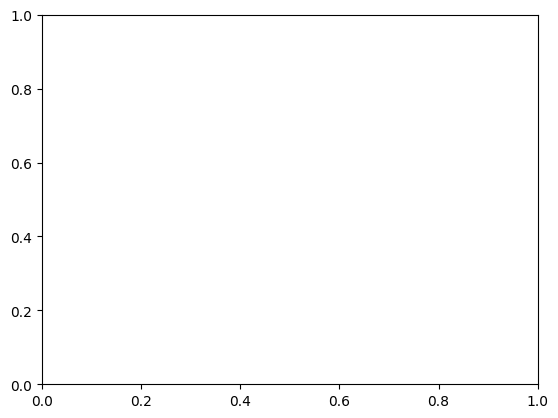

In [1]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

map = ax.imshow(likelihoods[:, -1, :]/1000)

ax.set_xlabel('v0')
ax.set_ylabel('alpha')

ax.set_yticks(np.arange(len(alphas)))
ax.set_xticks(np.arange(len(v0s)))

ax.set_yticklabels(np.round(alphas, 2))
ax.set_xticklabels(np.round(v0s, 2))

# colorbar
cbar = fig.colorbar(map, ax=ax)
cbar.set_label('log likelihood (*1000)')

# x at minima
maxima = np.where(likelihoods == np.max(likelihoods))
ax.scatter(maxima[1], maxima[0], marker='o', color='black', label='maxima')

ax.legend()
plt.show()


# 4. Plot heatmap and find θ^(opt)

df